In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.sun import constants as const
from sunkit_instruments import suvi
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [3]:
def load_suvi(start=None, end=None, channel=195):
    """
    * 9.4 nm (FeXVIII)
    * 13.1 nm (FeXXI)
    * 17.1 nm (FeIX/X)
    * 19.5 nm (FeXII)
    * 28.4 nm (FeXV)
    * 30.4 nm (HeII)
    """
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/SUVI/{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}/{channel}A"
    root_filename = f"dr_suvi-l2-ci{channel}_g18_s"
    data = sorted(glob.glob(f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.fits"))
    
    start_file_to_find = f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0000Z_e{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0400Z_v1-0-2.fits"
    end_file_to_find   = f"{data_path}/{root_filename}{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}2800Z_e{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}3200Z_v1-0-2.fits"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = suvi.files_to_map(file, despike_l1b=True)
        min_range = 0
        if channel == 94:
            max_range = 20
        elif channel == 171:
            max_range = 20
        elif channel == 131:
            max_range = 20
        elif channel == 195:
            max_range = 50
        elif channel == 284:
            max_range = 50
        elif channel == 304:
            max_range = 100
        
        m.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
        map_objects.append(m)
        print(f'SUVI image {i} is done')
    return map_objects



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps, vmin=0, vmax=2):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs:
            - list of EUV sunpy maps.
            - range of the clipping threshold.
        Output:
            - sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=vmin, vmax=vmax)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax

In [4]:
suvi_map_objects  = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=195)
clean_suvi_maps   = remove_redundant_maps(suvi_map_objects)
suvi_seq_runratio = apply_runratio(clean_suvi_maps)

for m in suvi_seq_runratio:
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


In [5]:
# # Test ...
# m = suvi_seq_runratio[5]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m)
# img = m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# plt.colorbar(img, pad=0.02, shrink=0.8)
# plt.show()

In [6]:
# subset_suvi = [ suvi_seq_runratio[7], suvi_seq_runratio[6], suvi_seq_runratio[5] ]

# fig = plt.figure(figsize=[13,5])

# for i, m_suvi in enumerate(subset_suvi):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_suvi)
#     m_suvi.plot(axes=ax)
#     m_suvi.draw_limb()
#     ax.grid(False)
    
#     if i == 1 or i == 2:
#         ax.set_ylabel(' ')
#         ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
# plt.show()

In [7]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')

# remove redundant images
clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)

print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)} images\n')
print(f'After:\nLASCO C2: {len(clean_maps_c2)} images')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

2025-02-04 11:22:54 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:22:58 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


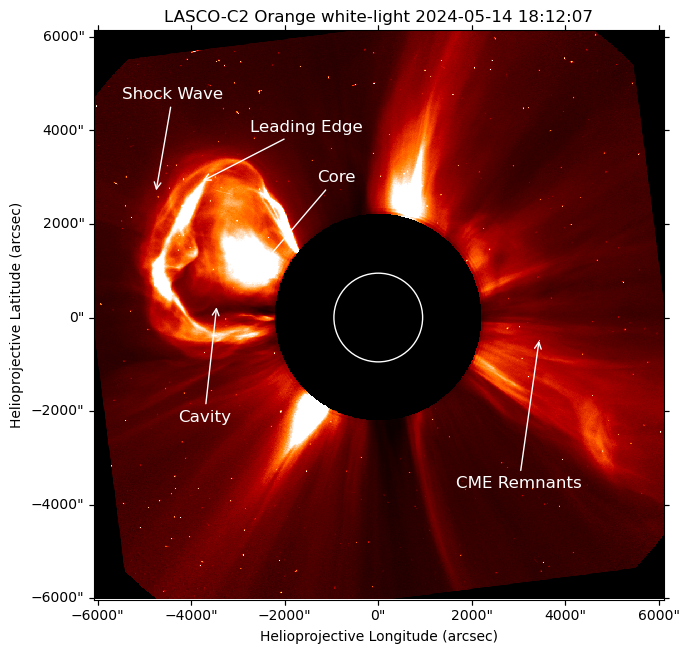

In [8]:
# Test ...
m = clean_maps_c2[4]

fig = plt.figure(figsize=[7,7], layout='constrained')
ax = fig.add_subplot(projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
ax.set_xlabel('Helioprojective Longitude (arcsec)')
ax.set_ylabel('Helioprojective Latitude (arcsec)')

ax.annotate('Core', xy=(300, 600), xytext=(400, 750),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Cavity', xy=(220, 530), xytext=(150, 320),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Leading Edge', xy=(190, 750), xytext=(280, 840),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Shock Wave', xy=(110, 730), xytext=(50, 900),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('CME Remnants', xy=(800, 470), xytext=(650, 200),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

fig.tight_layout()
# fig.savefig(f'{data_dir}/c2_whitelight.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [9]:
# subset_c2 = clean_maps_c2[2:5][::-1]

# fig = plt.figure(figsize=[13,5])

# for i, m_c2 in enumerate(subset_c2):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c2)
#     m_c2.plot(axes=ax)
#     m_c2.draw_limb()
#     ax.grid(False)

# fig.tight_layout()
# plt.show()

In [10]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)

In [11]:
# # Test ...
# m_c2_rr = m_seq_runratio_c2[2]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m_c2_rr)
# img = m_c2_rr.plot(axes=ax)
# m_c2_rr.draw_limb()
# ax.grid(False)
# plt.colorbar(img, pad=0.02, shrink=0.8)
# plt.show()

In [12]:
# subset_runratio_c2 = [ m_seq_runratio_c2[3], m_seq_runratio_c2[2], m_seq_runratio_c2[1] ]

# fig = plt.figure(figsize=[13,5])

# for i, m_c2 in enumerate(subset_runratio_c2):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c2)
#     m_c2.plot(axes=ax)
#     m_c2.draw_limb()
#     ax.grid(False)
#     ax.set_title(m_c2.latex_name.replace('Orange white-light ', ''))
    
#     if i == 1 or i == 2:
#         ax.set_ylabel(' ')
#         ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
# plt.show()

In [13]:
lasco_c3_map_objects = load_lasco(start='2024-05-14T17:45:00', end='2024-05-14T23:59:59', detector='C3')

LASCO C3 image 0 is done
LASCO C3 image 1 is done
LASCO C3 image 2 is done
LASCO C3 image 3 is done
LASCO C3 image 4 is done
LASCO C3 image 5 is done
LASCO C3 image 6 is done
LASCO C3 image 7 is done
LASCO C3 image 8 is done
LASCO C3 image 9 is done
LASCO C3 image 10 is done
LASCO C3 image 11 is done
LASCO C3 image 12 is done
LASCO C3 image 13 is done
LASCO C3 image 14 is done
LASCO C3 image 15 is done
LASCO C3 image 16 is done
LASCO C3 image 17 is done
LASCO C3 image 18 is done
LASCO C3 image 19 is done
LASCO C3 image 20 is done
LASCO C3 image 21 is done
LASCO C3 image 22 is done
LASCO C3 image 23 is done
LASCO C3 image 24 is done
LASCO C3 image 25 is done
LASCO C3 image 26 is done
LASCO C3 image 27 is done
LASCO C3 image 28 is done
LASCO C3 image 29 is done
LASCO C3 image 30 is done
LASCO C3 image 31 is done
LASCO C3 image 32 is done
LASCO C3 image 33 is done
LASCO C3 image 34 is done
LASCO C3 image 35 is done
LASCO C3 image 36 is done
LASCO C3 image 37 is done
LASCO C3 image 38 is d

In [14]:
# remove redundant images
clean_maps_c3 = remove_redundant_maps(lasco_c3_map_objects)

print(f'Before:\nLASCO C3: {len(lasco_c3_map_objects)} images\n')
print(f'After:\nLASCO C3: {len(clean_maps_c3)} images')

Before:
LASCO C3: 374 images

After:
LASCO C3: 29 images


In [15]:
# make run-diff maps
m_seq_runratio_c3 = apply_runratio(clean_maps_c3, vmin=0.6, vmax=1.4)

In [16]:
# # Test ...
# m = clean_maps_c3[13]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m)
# img = m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [17]:
# # Take 3 items starting from index 3, skipping n items in between
# # subset_c3 = clean_maps_c3[3:3 + 3*3:3][::-1]
# subset_c3 = clean_maps_c3[3:][::5][:3][::-1]

# fig = plt.figure(figsize=[15,5])

# for i, m_c3 in enumerate(subset_c3):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c3)
#     m_c3.plot(axes=ax)
#     m_c3.draw_limb()
#     ax.grid(False)
#     print(m_c3.meta['time_obs'])

# fig.tight_layout()
# plt.show()

In [18]:
# subset_runratio_c3 = [ m_seq_runratio_c3[12], m_seq_runratio_c3[7], m_seq_runratio_c3[2] ]

# fig = plt.figure(figsize=[15,5])

# for i, m_c3 in enumerate(subset_runratio_c3):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c3)
#     m_c3.plot(axes=ax)
#     m_c3.draw_limb()
#     ax.grid(False)

# fig.tight_layout()
# plt.show()

2025-02-04 11:29:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:09 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-04 11:29:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


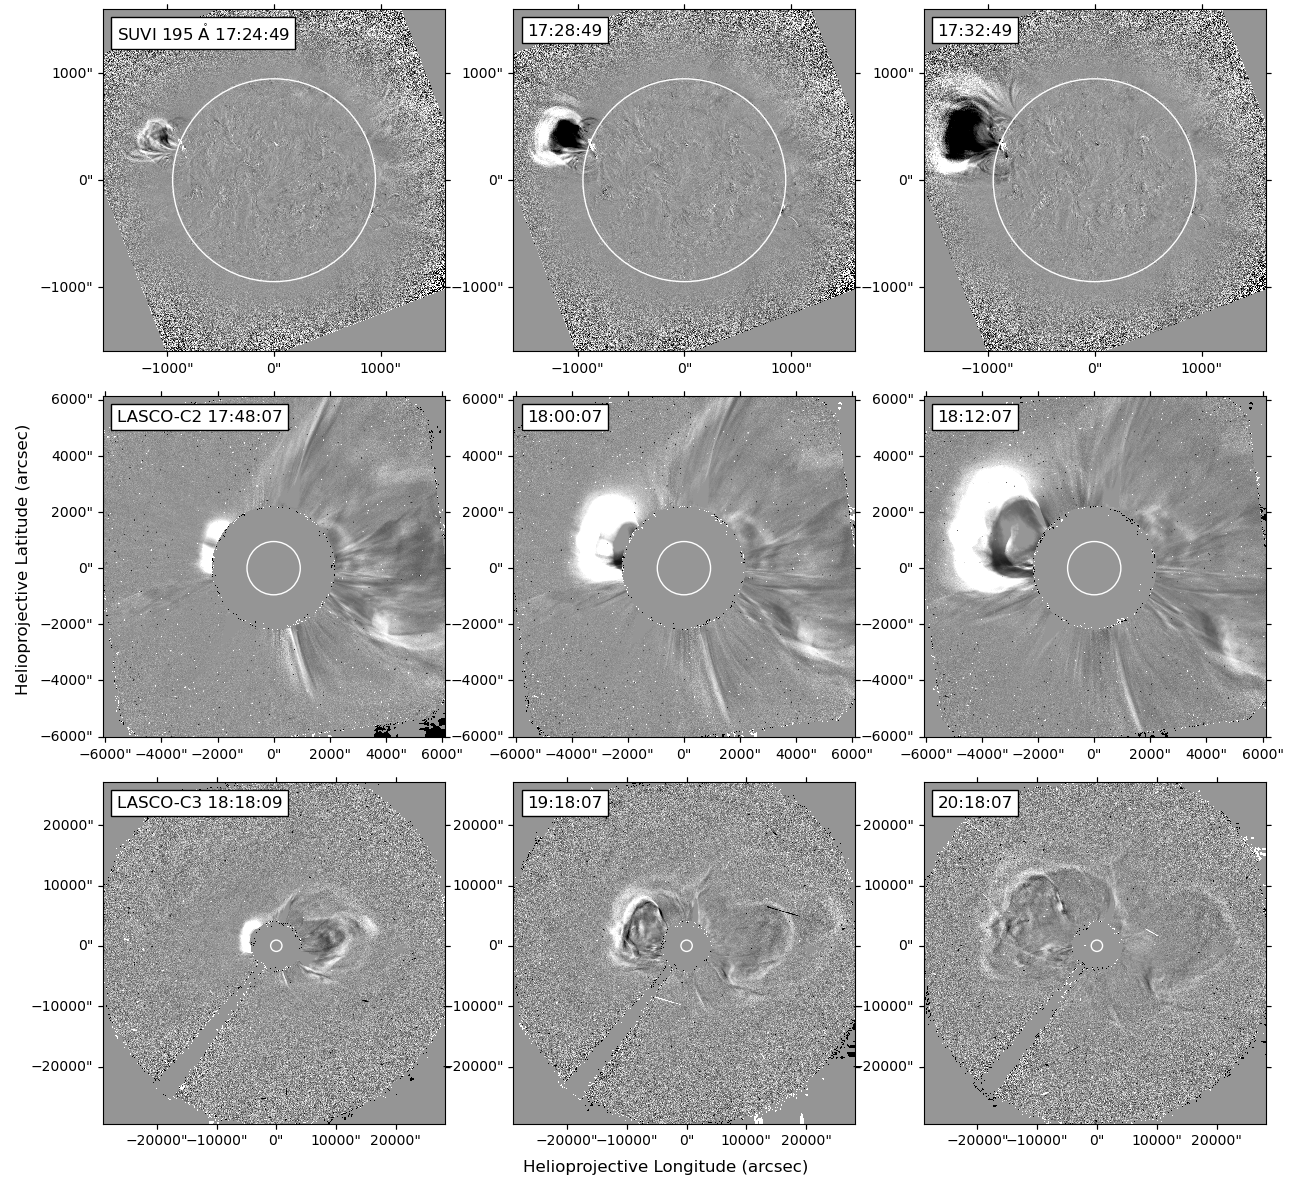

In [23]:
subset = [ suvi_seq_runratio[5], suvi_seq_runratio[6], suvi_seq_runratio[7], 
          m_seq_runratio_c2[1], m_seq_runratio_c2[2], m_seq_runratio_c2[3], 
          m_seq_runratio_c3[2], m_seq_runratio_c3[7], m_seq_runratio_c3[12] ]

# fig = plt.figure(figsize=[15,15], layout='constrained')
fig = plt.figure(figsize=[15,15])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.09)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.067)

for i, m in enumerate(subset):
    ax = fig.add_subplot(3, 3, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_limb()
    ax.grid(False)
    ax.set_title('')
    
    if i==0:
        label = m.latex_name.split(' 2024')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==1 or i==2:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==3:
        label = m.latex_name.split(' Orange')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==4 or i==5:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==6:
        label = m.latex_name.split(' Clear')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==7 or i==8:
        label = m.latex_name.split('2024-05-14 ')[-1]
    
    ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    # ax.text(0.03, 0.955, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    # ax.text(0.025, 0.05, m.latex_name, horizontalalignment='left', color='k',
    #         verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
    
    # if 'SUVI' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('2024-05-14 ', ''))
    # elif 'LASCO-C2' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('Orange white-light 2024-05-14 ', ''))
    # elif 'LASCO-C3' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('Clear white-light 2024-05-14', ''))
    
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    # # hide tick labels
    # if i==0 or i==3:
    #     ax.coords[0].set_ticklabel_visible(False)
    # elif i==7 or i==8:
    #     ax.coords[1].set_ticklabel_visible(False)
    # elif i==1 or i==2 or i==4 or i==5:
    #     ax.coords[0].set_ticklabel_visible(False)
    #     ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.01)  # Reduce whitespace
fig.savefig(f'{data_dir}/euv_runratio_panels.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [20]:
# clean_suvi_maps
# clean_maps_c2
# clean_maps_c3

In [21]:
# for m in clean_suvi_maps:
#     print(m.meta['date-obs'])

In [26]:
print(11.9*1024)
print( (11.9*1024)/2 )

12185.6
6092.8
